In [ ]:
# Import Packaes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning packages
from sklearn.preprocessing import StandardScaler  # Maybe use MinMaxScaler?
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score


# import warnings
# warnings.filterwarnings("ignore")

# Prevents Pandas Copy Warning
pd.set_option("mode.copy_on_write", True)

## Exploratory Data Analysis

In [3]:
# Load in the data
credit_card_data = pd.read_csv("data/creditcard_2023.csv.zip")

# Inspect the data
display(credit_card_data.sample(10))

print(f"Credit card dataset dimensions: {credit_card_data.shape}")

# Information about each variable
print("")

display(credit_card_data.info())

# Check for missing values
display(credit_card_data.isna().sum())

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
524957,524957,-0.583704,0.137049,-0.736568,0.920508,-0.069992,-1.210845,-0.935535,0.214617,-1.029342,...,0.296738,-0.135477,-0.748092,-0.764442,0.187109,0.844334,2.248957,1.334172,19648.57,1
38997,38997,-0.003170,-0.132545,1.633677,-0.625175,0.243506,0.115527,0.691079,-0.144743,0.234071,...,-0.171829,-0.399439,0.044487,0.821580,-0.557301,0.194201,0.100396,0.195642,10821.95,0
511755,511755,-1.386705,0.107629,-1.286959,1.576904,-0.450190,-1.876069,-2.021013,-0.102321,-0.995466,...,-0.313537,-1.196630,-11.139979,0.475617,-5.139127,0.250497,3.254548,-1.142056,17561.68,1
153233,153233,-0.094761,0.041796,0.101652,-1.274779,0.964571,-0.255587,1.228282,-0.310630,1.743495,...,-0.129472,0.534673,-0.257222,1.197399,-0.350708,0.012954,0.223596,0.583193,13061.77,0
2495,2495,-0.106244,-0.096056,0.984274,-0.846815,0.326126,0.912679,0.210387,-0.626746,0.479029,...,0.806163,-0.038554,0.131965,-1.429043,-1.384542,2.339584,0.136112,0.337451,23121.95,0
406225,406225,0.884730,-0.225940,0.480127,-0.069328,0.503273,0.334621,0.607742,-0.193719,0.205838,...,-0.124442,-0.096975,-0.098435,-0.351622,0.396397,-0.856725,-0.181343,-0.001325,15168.05,1
73434,73434,0.054850,-0.479427,1.513419,-1.118490,0.130226,0.569903,0.376809,-0.104538,-0.342840,...,-0.061451,0.003704,0.104611,-0.558317,-0.937172,-0.870764,-0.080432,0.208823,4886.30,0
28374,28374,-0.311066,-0.912566,0.726968,-0.899341,-0.332090,1.741612,1.001558,0.054222,1.184895,...,0.092739,0.789361,1.662925,-1.634198,-1.293393,-1.617014,-0.184898,0.337485,11143.33,0
106219,106219,-0.185582,-0.194373,0.987292,-0.106344,0.463249,0.108102,0.582463,-0.066418,-0.120435,...,-0.155978,-0.687991,0.158001,0.113709,-0.757893,-1.585119,-0.191575,-0.118350,6890.38,0
566137,566137,0.245747,0.652091,-0.758771,1.229024,1.053043,-0.553121,0.155309,-0.007899,-1.165522,...,-0.015921,-0.538483,-0.261377,-1.452060,0.018396,0.956902,0.290259,0.492090,21731.84,1


Credit card dataset dimensions: (568630, 31)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2      568630 non-null  float64
 3   V3      568630 non-null  float64
 4   V4      568630 non-null  float64
 5   V5      568630 non-null  float64
 6   V6      568630 non-null  float64
 7   V7      568630 non-null  float64
 8   V8      568630 non-null  float64
 9   V9      568630 non-null  float64
 10  V10     568630 non-null  float64
 11  V11     568630 non-null  float64
 12  V12     568630 non-null  float64
 13  V13     568630 non-null  float64
 14  V14     568630 non-null  float64
 15  V15     568630 non-null  float64
 16  V16     568630 non-null  float64
 17  V17     568630 non-null  float64
 18  V18     568630 non-null  float64
 19  V19     568630 non-null  float64
 20  V2

None

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

After loading in the dataset we observe the following:

- There are 284,807 observation and 31 variables.
- All variables are floats types except for `Class` which is an integer
- There are no missing values

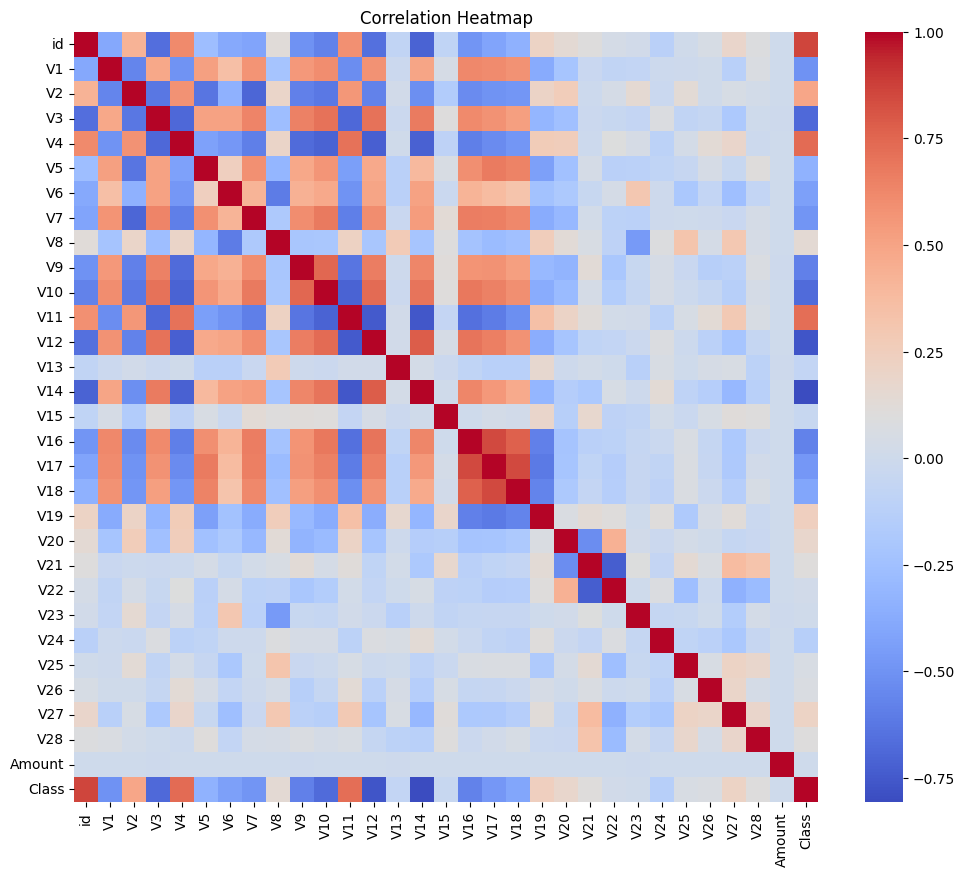

In [4]:
# Correlation Matrix Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(credit_card_data.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

Split data and scale. 

In [5]:
# Separate features and target
X = credit_card_data.drop("Class", axis=1)
y = credit_card_data["Class"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        f"{model.__class__.__name__} Classification Report:\n",
        classification_report(y_test, y_pred),
    )
    print(
        f"{model.__class__.__name__} ROC AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}\n"
    )


# Logistic Regression
logistic_model = LogisticRegression()
evaluate_model(logistic_model, X_train_scaled, y_train, X_test_scaled, y_test)

# Decision Tree
dtree_model = DecisionTreeClassifier()
evaluate_model(dtree_model, X_train, y_train, X_test, y_test)

# Random Forest
rforest_model = RandomForestClassifier()
evaluate_model(rforest_model, X_train, y_train, X_test, y_test)

# Gradient Boosting
gboost_model = GradientBoostingClassifier()
evaluate_model(gboost_model, X_train, y_train, X_test, y_test)

# XGBoost
xgb_model = XGBClassifier(eval_metric="logloss")
evaluate_model(xgb_model, X_train, y_train, X_test, y_test)

LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

LogisticRegression ROC AUC Score: 0.9998071705165726

DecisionTreeClassifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726

DecisionTreeClassifier ROC AUC Score: 0.9995603467984454



KeyboardInterrupt: 